<a href="https://www.kaggle.com/code/danielreuter/ubiquant-competition-eda?scriptVersionId=91149840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import AgglomerativeClustering
!pip install hdbscan
import umap, hdbscan
import pickle
from scipy.stats import pearsonr
from typing import Tuple
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     |████████████████████████████████| 5.2 MB 1.5 MB/s            
  Installing build dependencies ... - \ | / - \ | / - \ | / done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=3413312 sha256=649abf353199697cb8099bd3d77bf848f88b1cc20156a96ae378a8b982c4361f
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan
/kaggle/input/version2/results2.pkl
/kaggle/input/ubiquant-market-prediction/example_sample_submission.csv
/kaggle/input/ubiquant-market-prediction/example_test.csv
/kaggle/input/ubiquant-market-prediction/train.csv
/kaggle/input/ubiquant-market-prediction/ubiquant/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/ubiquant-market-prediction/ubiquant/__init__.py
/kaggle/input/low-memory-pickle/__results__.h

# Overview of the data

In [2]:
train    = pd.read_pickle('/kaggle/input/low-memory-pickle/train.pkl')

features = [col for col in train.columns if col.startswith('f_')]
target   = 'target'

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3141410 entries, 0 to 1219
Columns: 302 entries, investment_id to f_299
dtypes: float16(301), int16(1)
memory usage: 1.8 GB


In [4]:
train.head()

,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
time_id,,,,,,,,,,,,,,,,,,,,,
0,1,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
0,2,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
0,6,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
0,7,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
0,8,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [5]:
train.isnull().sum().sum()

0

In [6]:
# How many time_ids are there?
len(train.index.unique())

1211

In [7]:
# How many investment_ids are there? 
len(train.investment_id.unique())

3579

Here we have a panel of 3579 different `investment_id`s across 1211 time periods, jointly indexing a target variable (presumably some sort of forward return) and 300 features. We don't know what the `time_id`corresponds to, nor what any of the features are, and thus the bulk of our work will presumably be on fine-tuning our models rather than feature engineering. 

# Exploration of the target variable

Let's take a look at the overall distribution of the target variable:

<AxesSubplot:title={'center':'Distribution of target variable'}, ylabel='Frequency'>

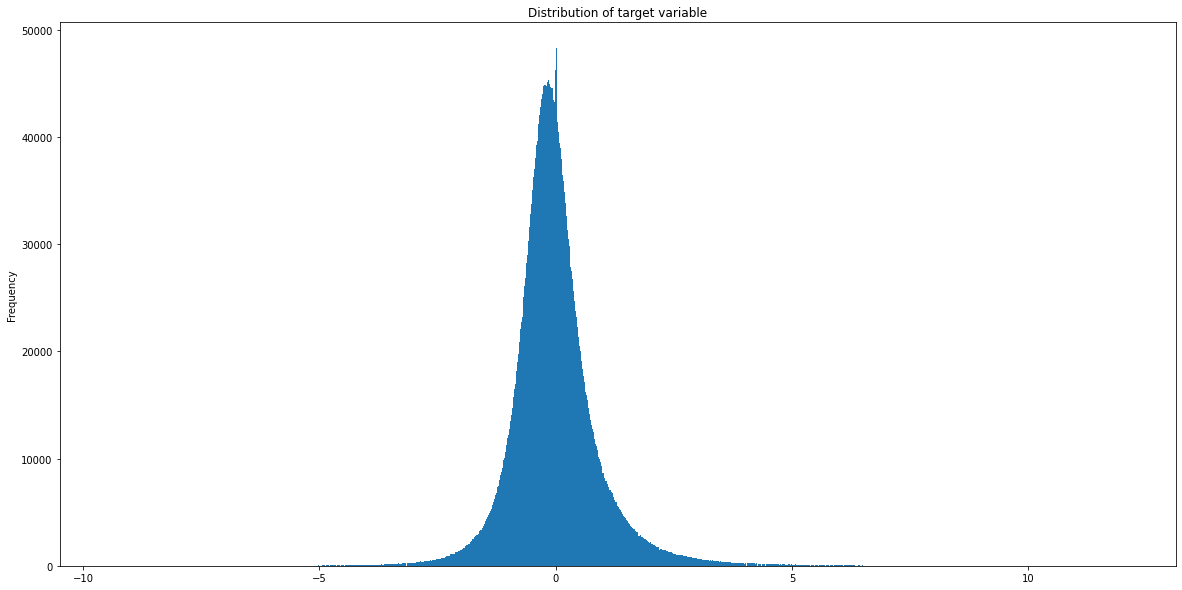

In [8]:
(train[target]
 .plot(kind='hist', 
       bins = 1000, 
       figsize = (20,10), 
       title='Distribution of target variable', 
       ylabel='Frequency'))

The general picture is pretty normal, if skewed somewhat to the right.

One thing that immediately jumps out is a discontinuity at 0. Let's first look into whether that's a data quality issue or not:

<AxesSubplot:title={'center':'Does the target variable bunch around 0?'}, xlabel='Target (binned)', ylabel='Frequency'>

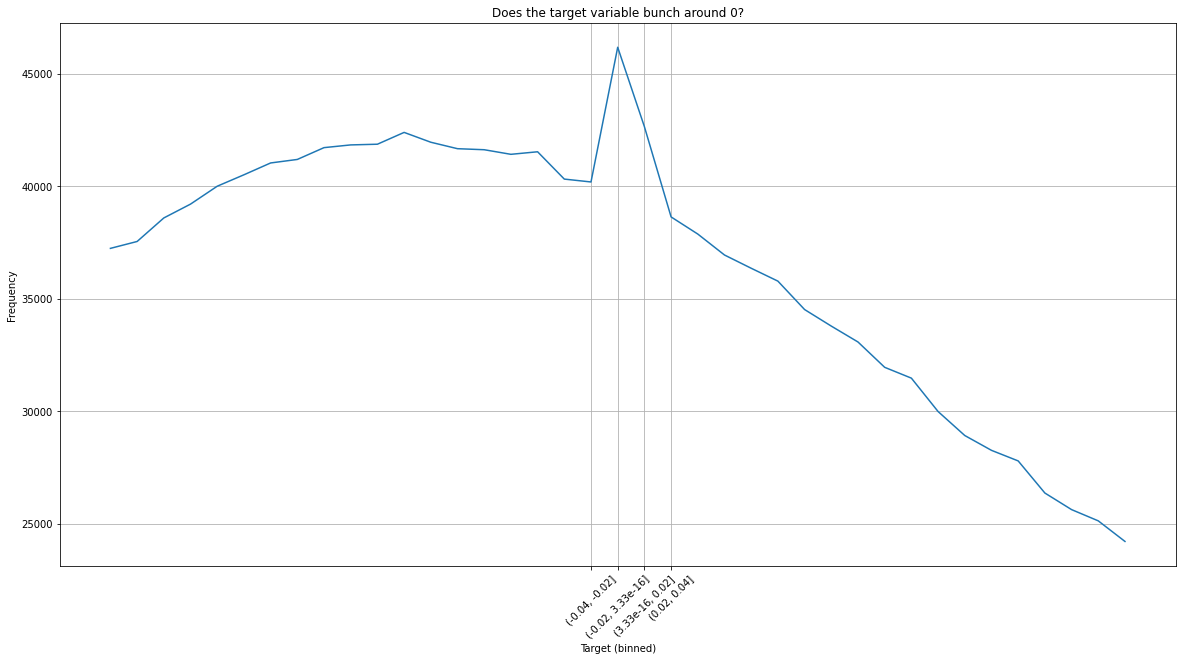

In [9]:
# Graph a narrow bandwidth around 0 just to confirm
(train[target]
 .groupby(pd.cut(train[target], bins=np.arange(-0.4,0.4,0.02)))
 .count()
 .plot(rot=45, 
       title='Does the target variable bunch around 0?', 
       ylabel='Frequency', 
       xlabel='Target (binned)',
       xticks=np.arange(18,22),
       grid=True,
       figsize=(20, 10)))

There's a clump of data at 0 -- 0s are about 10% more frequent than values in the neighborhood. 

Is this a problem with the data? Maybe not: I could see a world in which financial data is truly discontinuous at 0, e.g. if our target is a forward return and between two periods no one trades the underlying asset, then its price won't change and the return will be zero. If so, then there's no need to worry about this. I'd be curious, though, to see if the frequency of 0s varies by `time_id`or `investment_id`, which might reflect artifacts in the data that we'd want to cut out of our training set. 

Let's plot the distribution of the share of zeros, first by `investment_id`, then by time_id:

In [10]:
train['temp'] = train[target].between(-0.02, 0.02)



<AxesSubplot:ylabel='Frequency'>

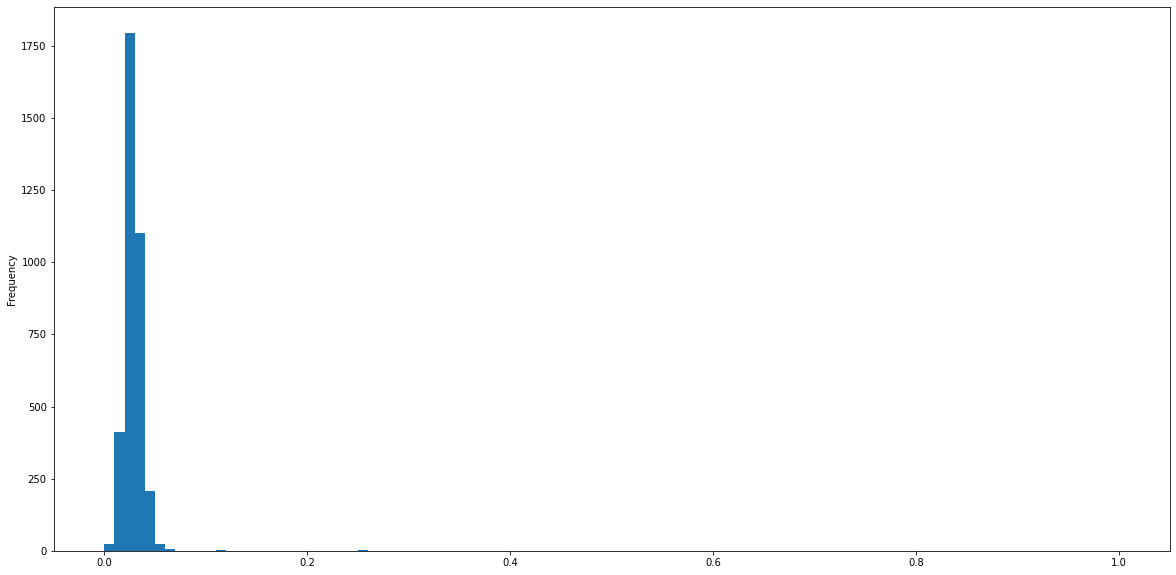

In [11]:
(train
 .groupby('investment_id')['temp']
 .mean()
 .plot(kind='hist',
       bins=100,
       figsize=(20, 10)))

The left-hand side of this plot shows nothing out of the ordinary. Let's see what those outliers are:

In [12]:

(train
 .groupby('investment_id')['temp']
 .aggregate(['mean','count'])
 .sort_values('mean', ascending=False)[:30])


,mean,count
investment_id,,
1415,1.000000,2
2800,0.666667,3
3662,0.285714,7
2558,0.250000,8
905,0.250000,8
85,0.250000,8
1573,0.166667,24
890,0.117647,17
2717,0.114286,35


As you can see, investments that only show up a handful of times in the data are the outliers -- although this doesn't tell us much, as it's consistent even with the null hypothesis that the true fraction of zeros per `investment_id` is constant (i.e. this could just reflect sampling variation). That being said it seems sensible to throw out the most sparse `investment_id`s, because they basically have no variation in the target variable and are unlikely to show up in the evaluation data. 

Does the fraction of zeros vary across time?

<AxesSubplot:ylabel='Frequency'>

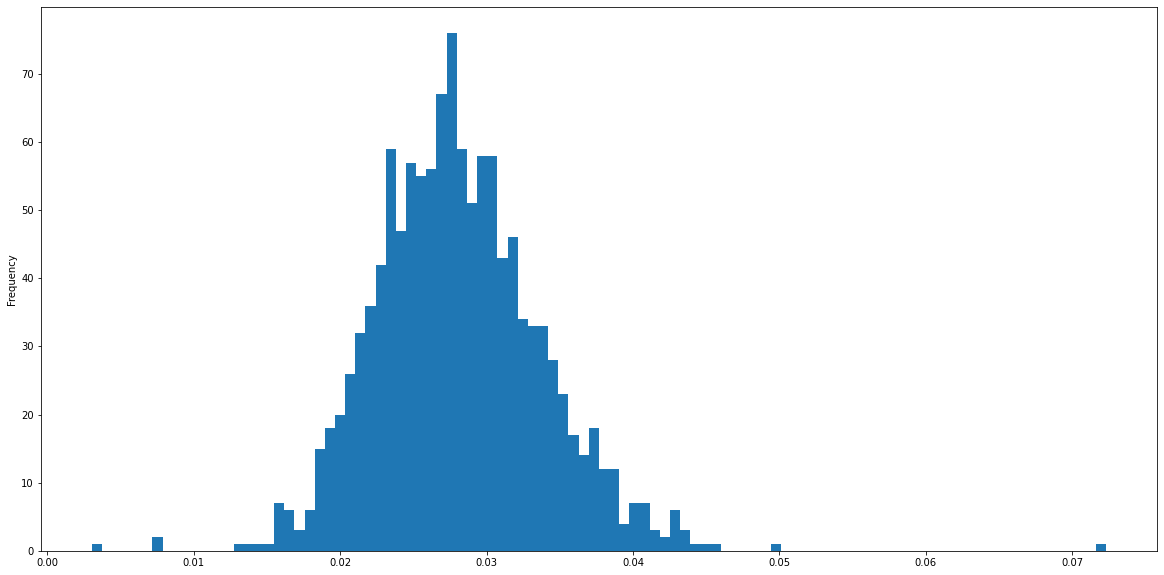

In [13]:
(train
 .groupby('time_id')['temp']
 .mean()
 .plot(kind='hist',
       bins=100,
       figsize=(20, 10)))

Again, nothing really jumps out as an obvious data problem. Let's see where the outliers are.

Below is a list of time_ids in descending order of fraction of zeros:

In [14]:
(train
 .groupby('time_id')['temp']
 .aggregate(['mean','count'])
 .sort_values('mean', ascending=False)[:30])

,mean,count
time_id,,
367,0.072321,1120
426,0.049598,2238
573,0.045677,2452
748,0.044679,2753
915,0.044524,3077
341,0.043847,1414
614,0.043738,2515
1133,0.043255,3306
1151,0.043189,3311


There's an issue with time_id==367 -- notice how the mean discontinuously jumps? However, quantitatively this isn't enough to drive the +10,000 excess zeros we see in the distribution of the target variable. I conclude that the zeros are valid data that we should train on, but also that there might be something strange going on with the time_ids, especially around time_id==367. 

In [15]:
del train['temp']

Lastly, here, let's see how the target variable was standardized. I'd guess that it's something like z-scores across `investment_id` within time_id, or maybe vice-versa. Let's see:

<AxesSubplot:title={'center':"Distribution of target's mean and standard deviation within investment_id across time_id"}, ylabel='Frequency'>

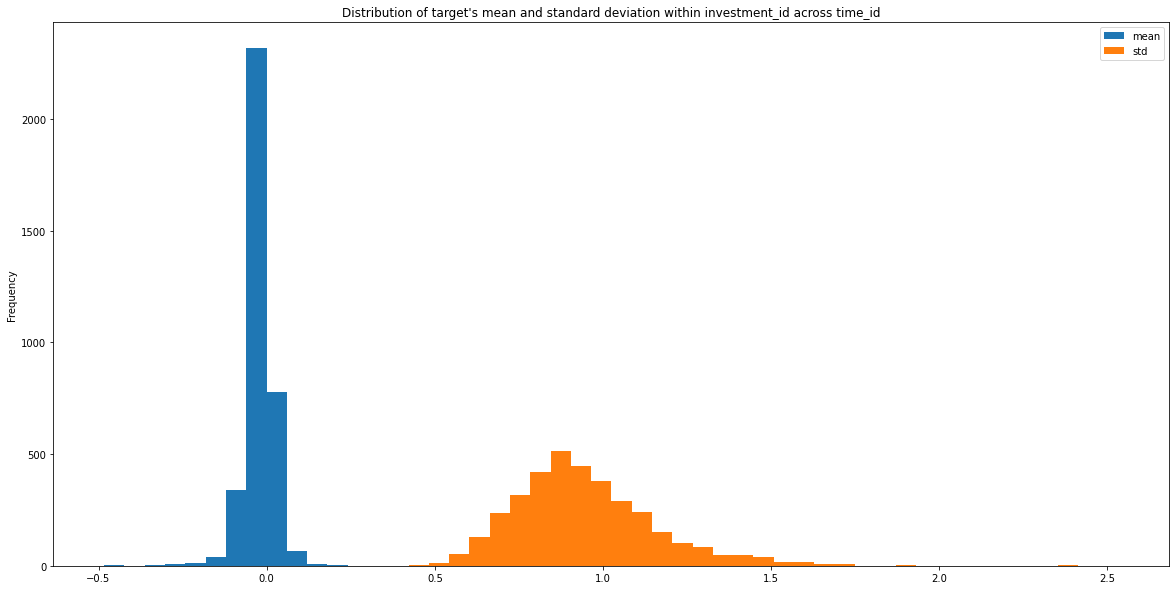

In [16]:
(train
 .groupby('investment_id')['target']
 .aggregate(['mean', 'std'])
 .plot(kind='hist', 
       bins=50, 
       figsize = (20,10), 
       title='Distribution of target\'s mean and standard deviation within investment_id across time_id'))

<AxesSubplot:title={'center':"Distribution of target's mean and standard deviation within `time_id`across investment_id"}, ylabel='Frequency'>

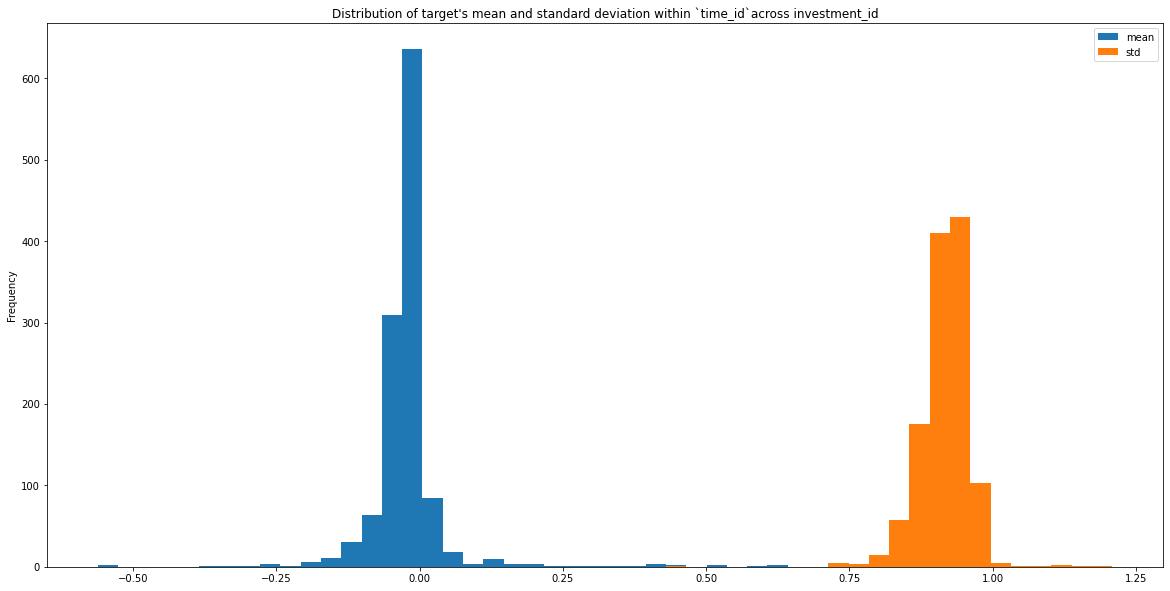

In [17]:
(train
 .groupby('time_id')['target']
 .aggregate(['mean', 'std'])
 .plot(kind='hist', 
       bins=50, 
       figsize = (20,10), 
       title='Distribution of target\'s mean and standard deviation within `time_id`across investment_id'))

Generally it looks like it's standardized within-time_id, although not perfectly -- perhaps they enforce standard rolling means and variances over some time. Regardless I think it's pretty clear that we don't need to do much or any additional work cleaning the target variable, at least for now.

# Exploration of the time dimension

We already know that the panel isn't balanced, so let's look into that. Below we have descriptive stats of the count of time_ids across `investment_id`s -- clearly there is a wide range of time periods covered in each investment.

In [18]:
(train
 .groupby('investment_id')['target']
 .count()
 .describe())

count    3579.000000
mean      877.734004
std       314.977410
min         2.000000
25%       683.000000
50%      1009.000000
75%      1131.000000
max      1211.000000
Name: target, dtype: float64

Let's get a sense for what these investments actually look like by picking 10 randomly and plotting the target for each of them over time:

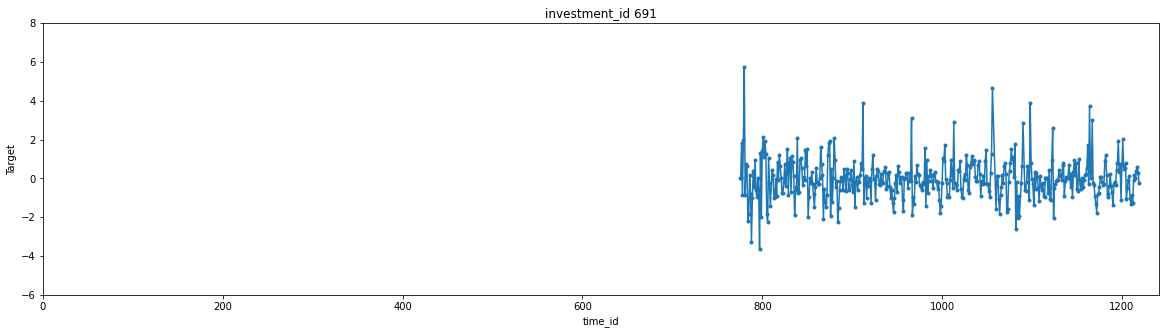

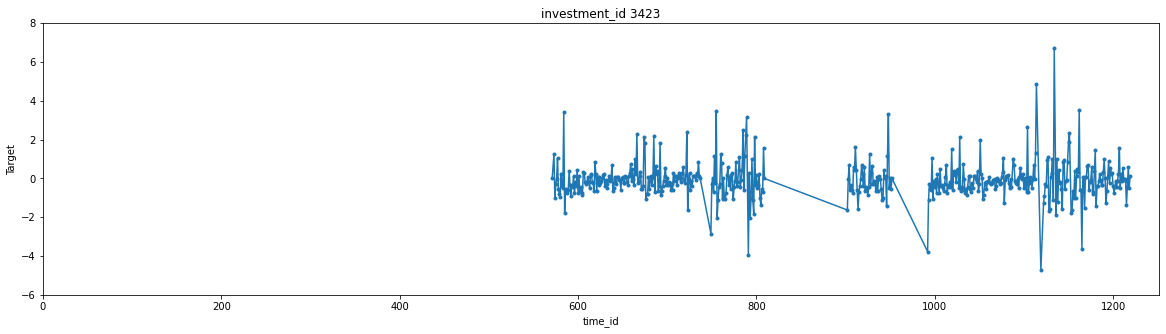

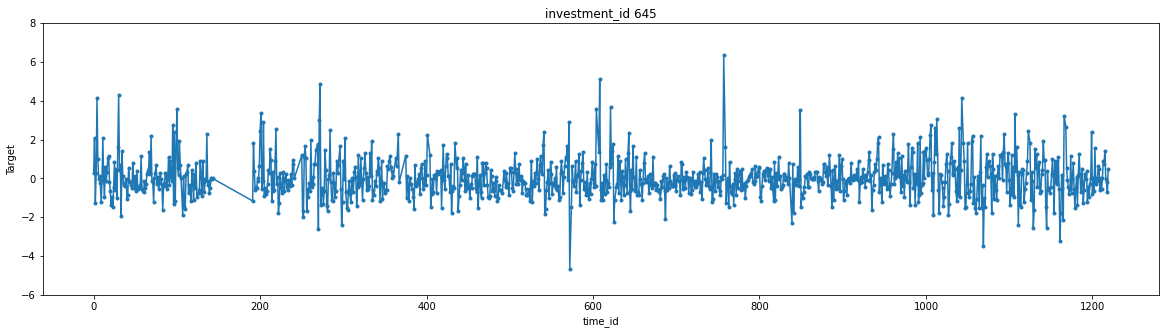

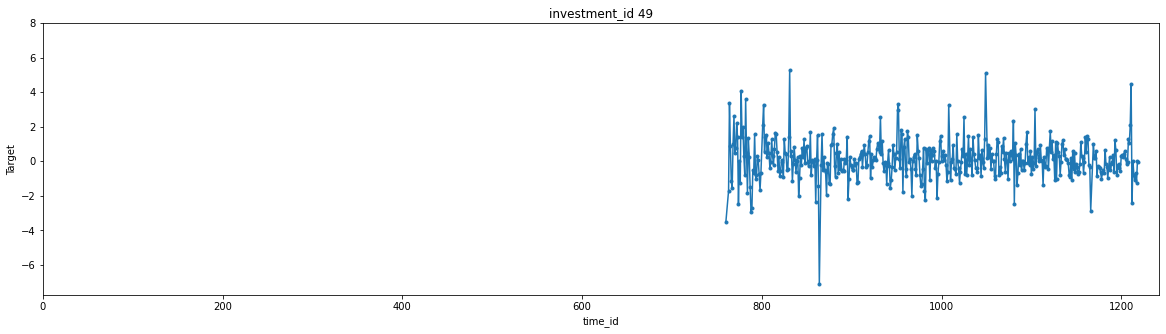

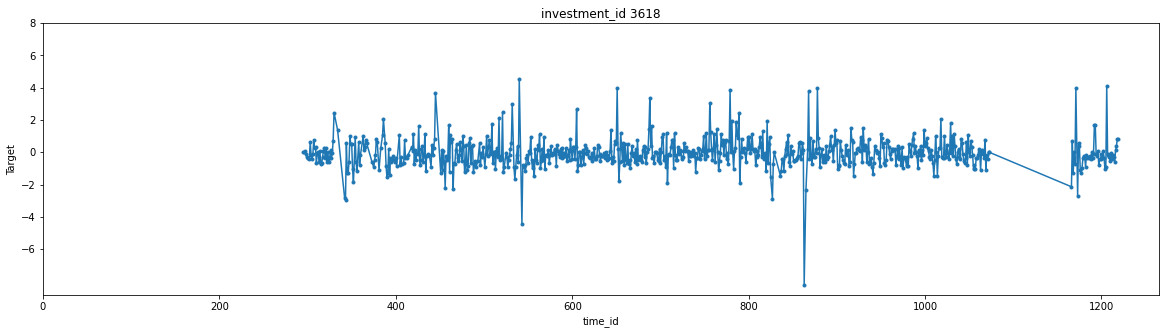

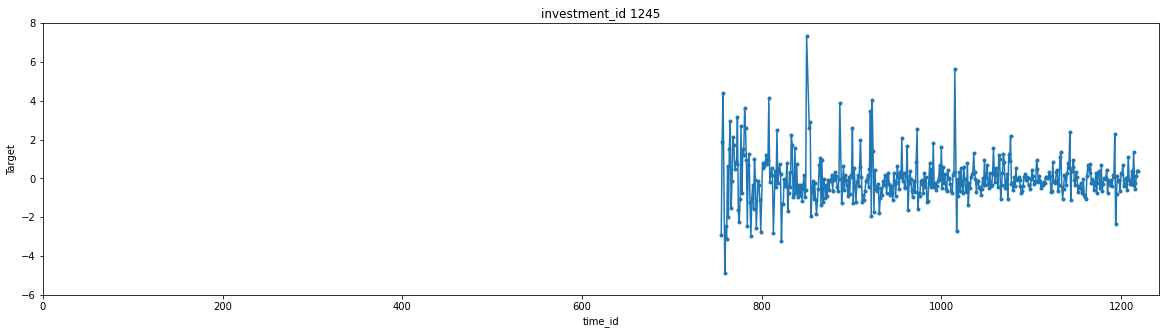

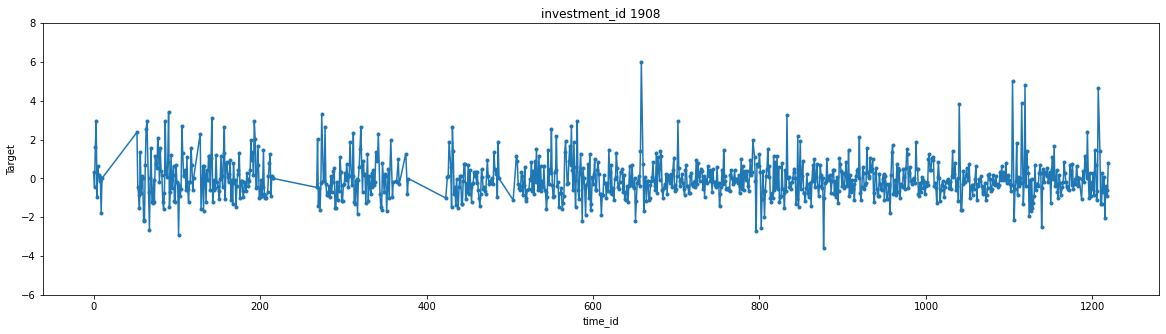

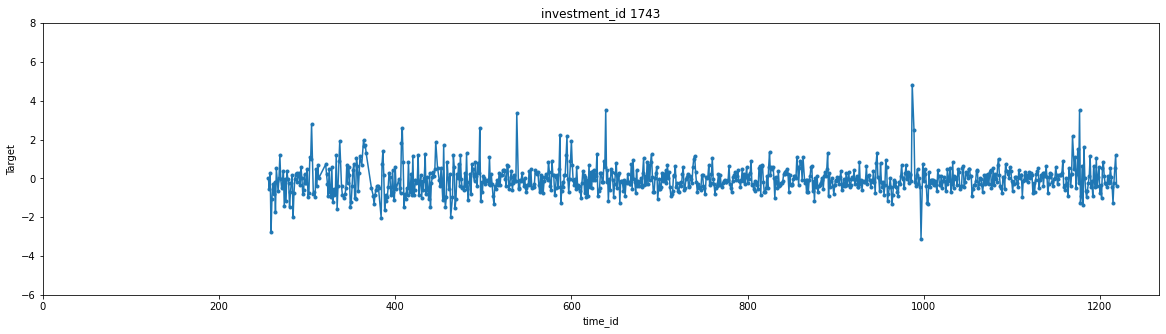

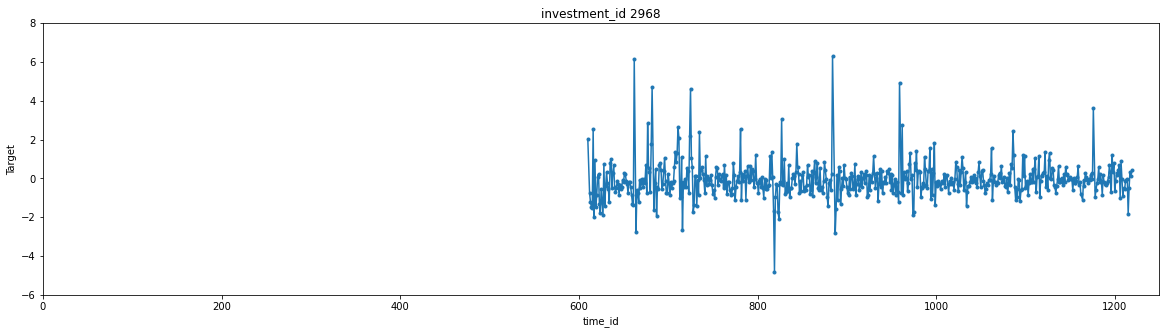

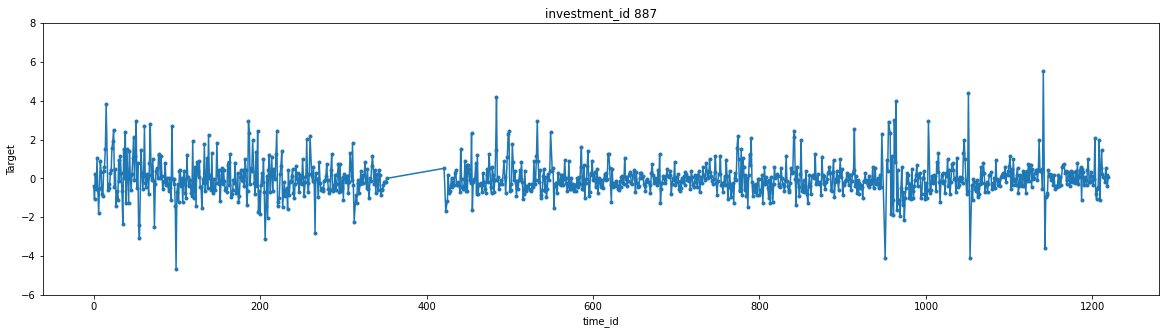

In [19]:
import matplotlib.pyplot as plt
for k in np.random.choice(train['investment_id'].unique(), 10):
    d = train[train['investment_id']==k]
    d['target'].plot(figsize=(20, 5),
                     title=f'investment_id {k}',
                     style='.-',
                     yticks=np.arange(-6, 9, 2),
                     xticks=np.arange(0, 1300, 200),
                     ylabel='Target')
    plt.show()

These series look mostly like noise, although presumably with a degree of mean reversion. The main thing that stands out to me is the missing data -- there are gaps in the time series of varying lengths, sometimes long, sometimes short. 

Below is a quick way to visualize time coverage in the aggregate: a scatter plot with `investment_id` on the y-axis and `time_id`on the x-axis, with each dot reflecting coverage for that (x,y) pair. 

<AxesSubplot:xlabel='time_id', ylabel='investment_id'>

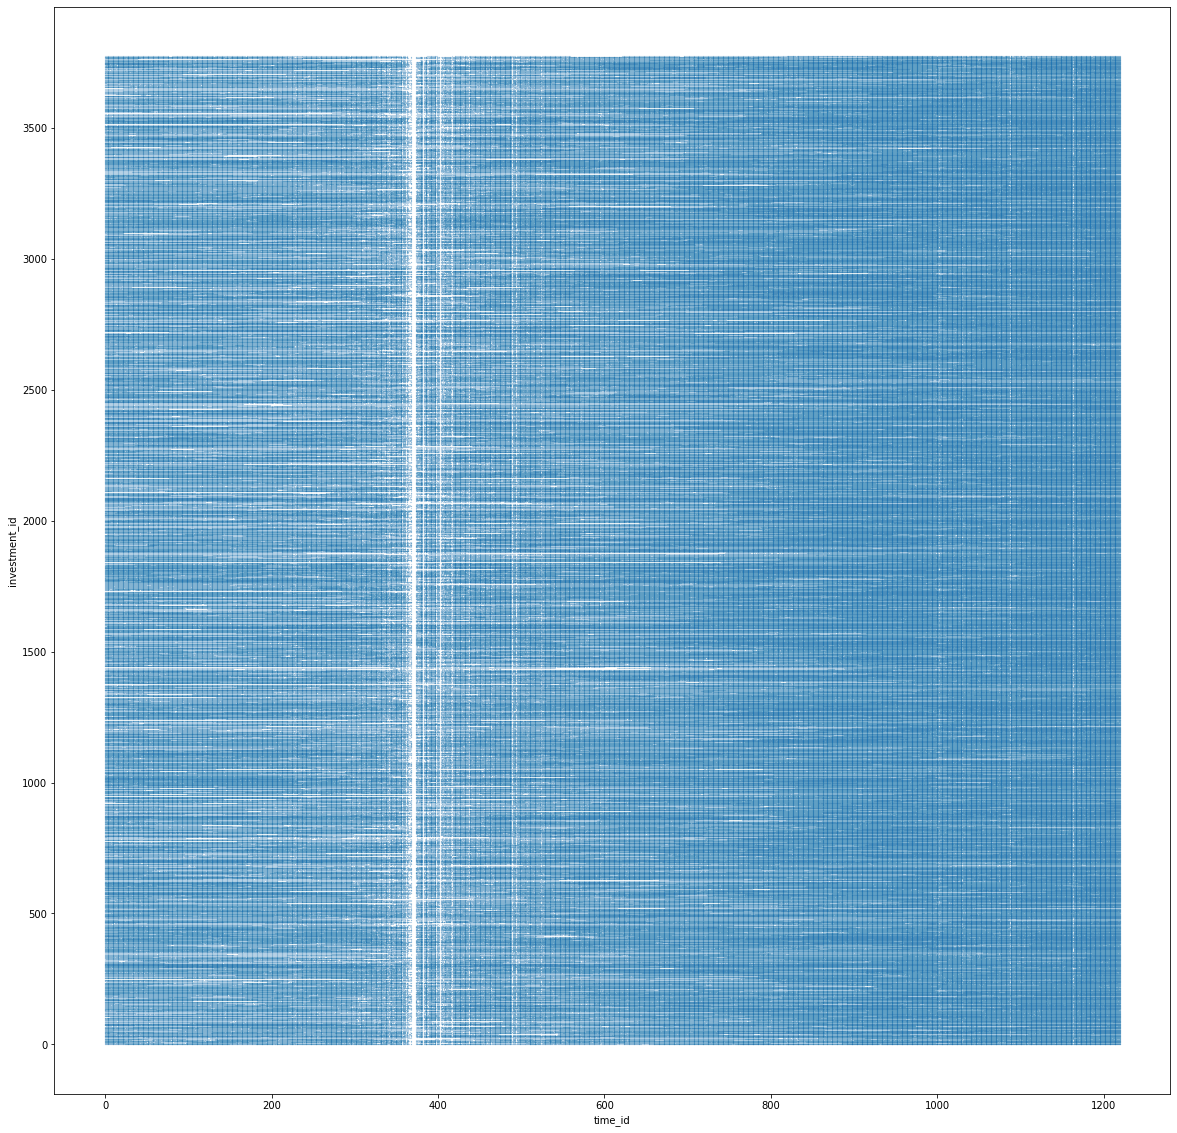

In [20]:
train['time_id'] = train.index
(train
 .plot
 .scatter(y='investment_id', 
          x='time_id', 
          figsize = (20, 20), 
          s=0.01))

The vertical white streak around `time_id`==370 is interesting -- note that this is where we saw a preponderance of 0s. I wonder if it corresponds to the market crash in early March 2020. If so, then the market dynamics before and after that vertical band are presumably quite different, and we should try training a version of the model with that early period excluded. 

The tab below shows us that `time_id`is missing between 367 and 373:

In [21]:
(train
 .groupby(by=train.index)
 .count()['target'][350:375])

time_id
350    2080
351    2057
352    2047
353    2024
354    2013
355    2116
356    2052
357    1094
358    2113
359    2147
360    2078
362     651
363    1904
364    1275
365     697
366     696
367    1120
373     996
374     600
375    1867
376    1517
377    1812
378    1873
379    1994
380    1876
Name: target, dtype: int64

One way to infer whether or not that period around `time_id`==370 is the Covid market crash (or at least some sort of unique financial event) would be to look for substantially heightened volatility around that time, because we know that the target isn't perfectly standardized within-`time_id`. Plotting the cross-sectional standard deviation in the target variable over time, we find exactly that:

<AxesSubplot:title={'center':'Standard deviation of the target variable across investments over time'}, xlabel='time_id'>

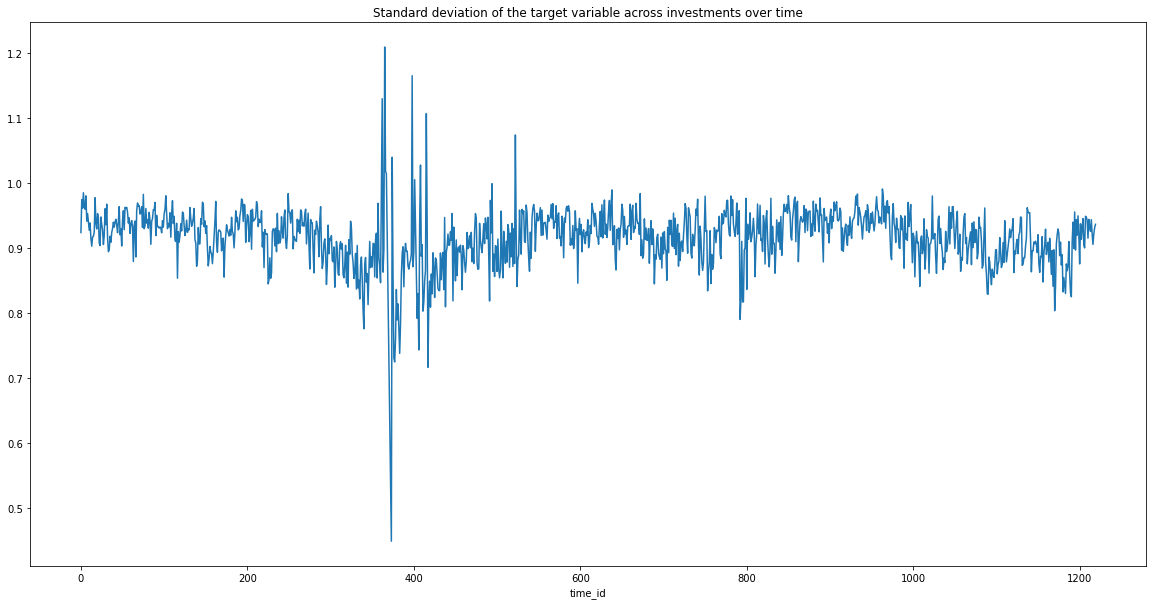

In [22]:
(train
 .groupby(by=train.index)['target']
 .std()
 .plot(figsize=(20,10),
       title="Standard deviation of the target variable across investments over time"))

There's unusual volatility around this period of missing data -- clearly we should run versions of our models in which we've excluded data from this time period (and potentially from before it as well) from the training set, as it's unlikely that whatever was going on then is a good guide to the evaluation period in spring 2022. 

We saw earlier that the series for some of these investments don't span the entire observation window. The white horizontal streaks are missing `time_id`s -- they're all concentrated on the lefthand side of the plot, whereas the righthand side is pretty blue. I'm thinking that we should try cutting some of the investments that we only observe for a sliver of time or that go missing well before the most recent `time_id`, because they're unlikely to correlate well with future data. Let's plot the min/max `time_id`by `investment_id` to get a sense for the prevalence of this particular issue:

<AxesSubplot:title={'center':'Last `time_id`(blue) versus first `time_id`(red)'}, xlabel='time_id', ylabel='Percentile of investments'>

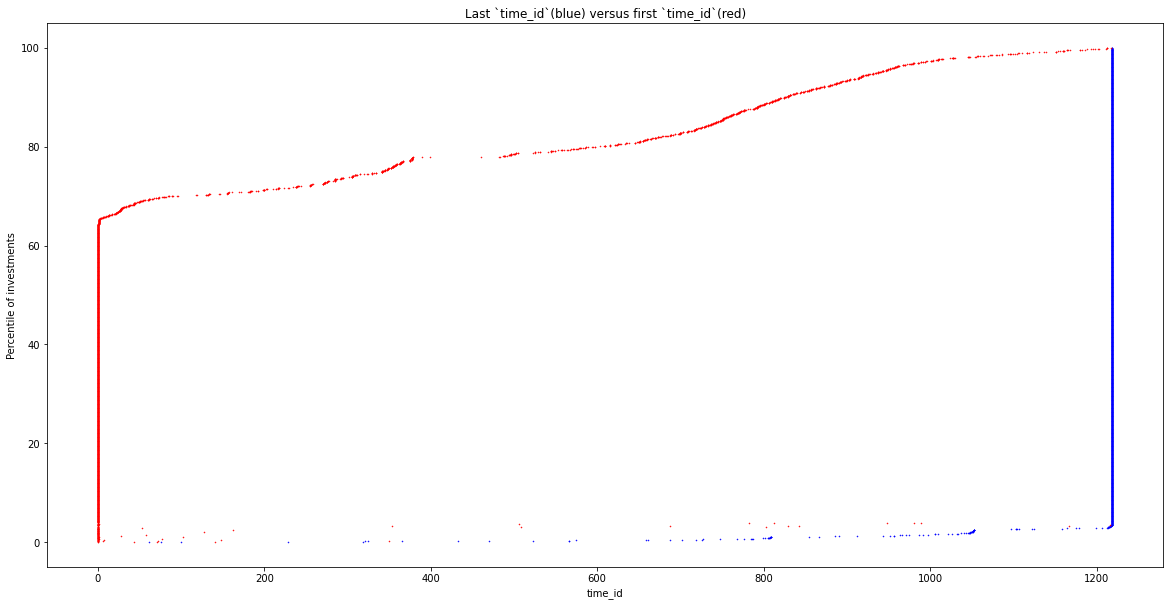

In [23]:
temp = (train
        .groupby('investment_id')['time_id']
        .aggregate(['min', 'max'])
        .sort_values(['max', 'min']))

temp['y'] = np.arange(len(temp))/len(temp)*100

ax1 = (temp
      .plot
      .scatter(y='y',
               x='max',
               figsize = (20, 10), 
               s=0.3, 
               c='blue', 
               title='Last `time_id`(blue) versus first `time_id`(red)', 
               xlabel='time_id',
               ylabel='Percentile of investments'))

(temp
 .plot
 .scatter(y='y',
          x='min', 
          s=0.3,  
          c='red', 
          ax=ax1, 
          xlabel='time_id',
          ylabel='Percentile of investments'))

Some observations:
1. ~60% of the investments have full time coverage (although this says nothing of how sparse they are)
2. Relatively few (~2%) of the investments do not have any data extending to the most recent time period -- among these, virtually all end after `time_id`==800 (i.e. it's not like they end at the very beginning of the observation window)
3. A solid chunk (~20%) of the investments only begin to have coverage halfway through the observation window

I think the principled way to deal with this is simply to drop the few investments that go missing before the end of the observation window because they're unlikely to show up in the evaluation set.

Let's look at the autocorrelations of the target for a subset of investments:

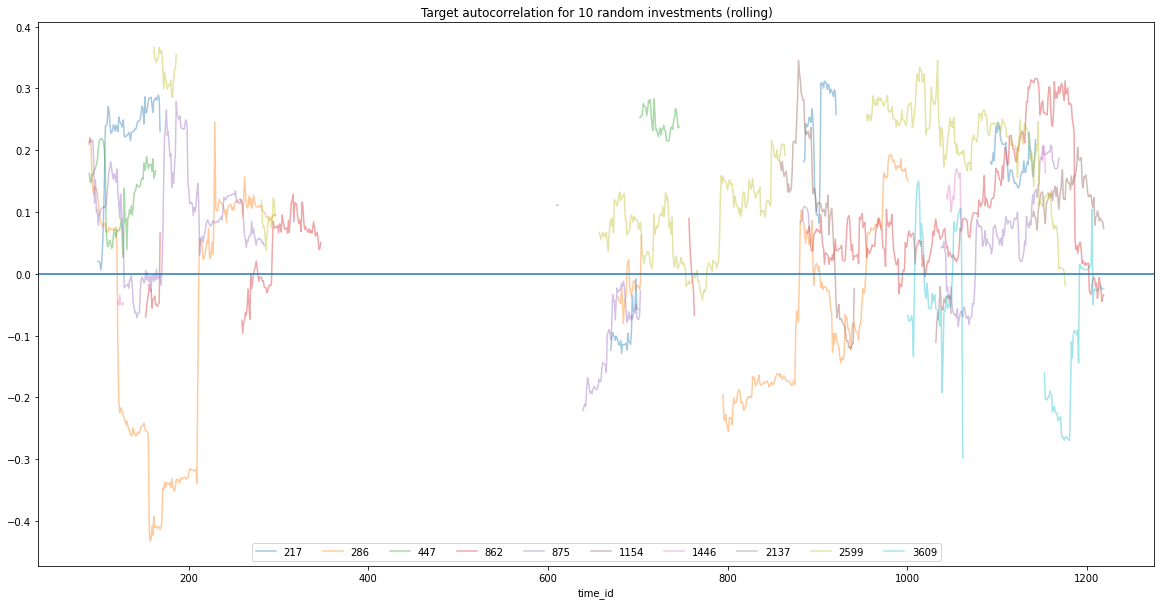

In [24]:
sample_tickers = np.random.choice(train['investment_id'].unique(), 10)
(train
 .query('investment_id in @sample_tickers')
 .set_index(['time_id', 'investment_id'])['target']
 .astype('float64')
 .unstack()
 .rolling(90)
 .apply(lambda x: x.autocorr(), raw=False)
 .plot(alpha=0.4,
       title='Target autocorrelation for 10 random investments (rolling)',
       figsize=(20,10))
 .legend(loc='lower center',
         ncol=len(sample_tickers)));
plt.axhline(0);

There's no clear pattern in the autocorrelations -- perhaps surprisingly it's more common for them to be positive than negative (I would have expected mean-reversion to be dominant here). 

However, I now think that time-series analysis is a no-go in this problem because of this line from the competition data page: 

> The time IDs are in order, but the real time between the time IDs is not constant and will likely be shorter for the final private test set than in the training set.

Clearly this precludes the use of lags as predictors -- if the people running the competition reduce the gap between successive time periods, then any lags in our models will be totally misspecified. So I think our best bet is to train a model that predicts purely based on cross-sectional variation. 

With that being said, let's look into the cross-sections: 

Drop investments that disappear before the end of the sample period and sparse investments:

In [25]:
train['time_max']   = (train
                       .groupby('investment_id')['time_id']
                       .transform('max'))
train['time_count'] = (train
                       .groupby('investment_id')['time_id']
                       .transform('count'))

In [26]:
train = train[(train['time_max']>1200) & (train['time_count']>10)]

In [27]:
del train['time_id']
del train['time_max']
del train['time_count']
del temp

# What do the features look like?

Let's get a sense for how the features relate to the target and to each other:

At a high level these things look very clean -- presumably they've already been standardized to mean zero and standard deviation 1 in some manner.



In [28]:
# Speed things up by taking a 10% sample
sample = train.sample(frac=.10)

<AxesSubplot:title={'center':'Distribution of unconditional mean and standard deviation across features'}, ylabel='Frequency'>

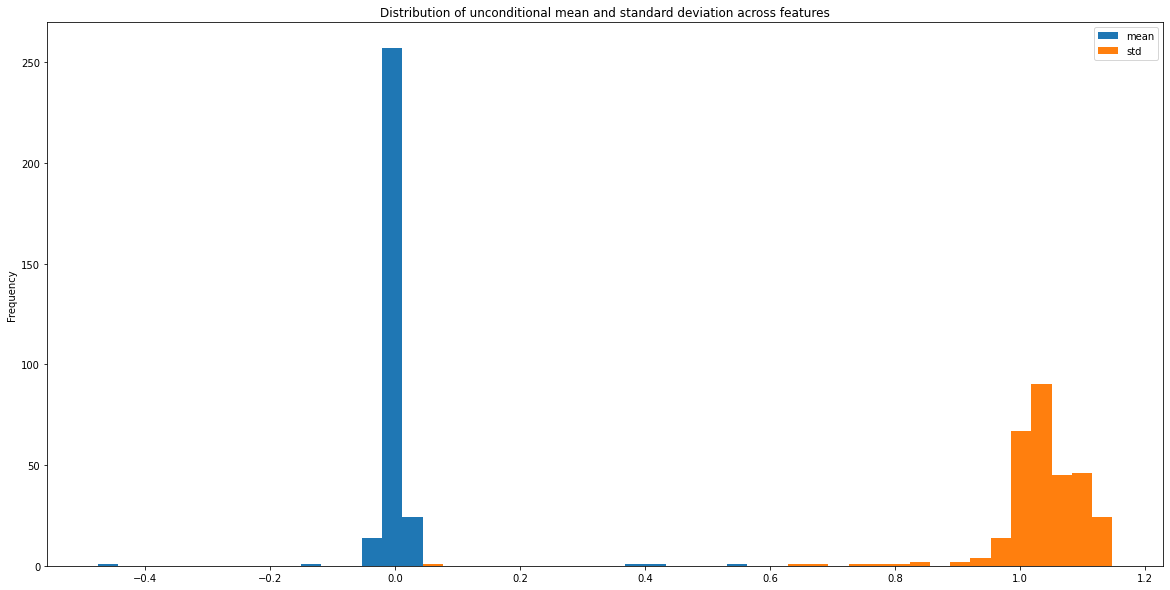

In [29]:
# Need to cast to float64 because the standard deviation function in groupby.aggregate() seems broken for float16 data
(train[features]
 .astype('float64')
 .aggregate(['mean', 'std'])
 .T
 .plot(kind='hist', 
       bins=50, 
       figsize = (20,10), 
       title='Distribution of unconditional mean and standard deviation across features')
)


In [30]:
temp = (train[features]
 .astype('float64')
 .aggregate(['mean', 'std'])
 .T)

In [31]:
temp.sort_values(by='mean')

,mean,std
f_175,-0.475095,0.676939
f_170,-0.126814,0.640568
f_200,-0.040593,0.795696
f_272,-0.033505,0.761953
f_250,-0.027986,0.999503
...,...,...
f_225,0.027199,1.055711
f_153,0.039198,0.841878
f_182,0.390200,0.753060
f_41,0.403822,0.930098


In [32]:
train[list(temp.sort_values(by='mean').iloc[:10].index)]

,f_175,f_170,f_200,f_272,f_250,f_280,f_214,f_193,f_65,f_172
time_id,,,,,,,,,,
0,-1.0,1.0,0.0,0.0,0.201416,-0.025604,0.186646,0.187866,0.662598,0.360107
0,-1.0,1.0,0.0,0.0,-0.491943,0.532227,0.727051,0.510742,-0.292480,0.409912
0,-1.0,1.0,0.0,0.0,-0.092407,-0.315430,-0.167603,-0.339355,0.309814,-0.446289
0,-1.0,1.0,0.0,0.0,-0.775391,-0.781250,-0.895508,-0.786133,-1.241211,-0.568848
0,-1.0,1.0,0.0,0.0,0.550293,0.894043,1.004883,0.814941,1.290039,1.234375
...,...,...,...,...,...,...,...,...,...,...
1219,0.0,-1.0,-1.0,-1.0,-0.918945,-0.540527,-0.626953,-0.432617,-1.055664,-0.291016
1219,0.0,-1.0,-1.0,-1.0,-0.699219,-0.515137,-0.884277,-0.668945,-1.176758,-0.397217
1219,0.0,-1.0,-1.0,-1.0,0.243164,1.396484,1.610352,-0.167358,1.231445,-0.237305


<AxesSubplot:ylabel='Frequency'>

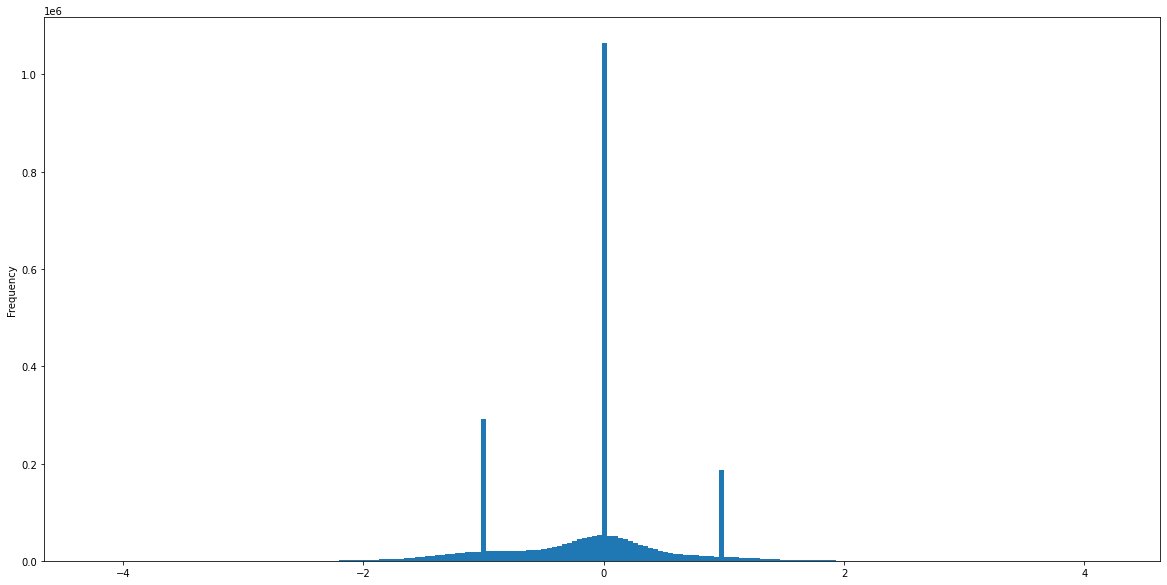

In [33]:
train['f_170'].plot(kind='hist', bins=200, figsize=(20,10))

In [34]:
train[list(temp.sort_values(by='mean', ascending=False).iloc[:10].index)]

,f_246,f_41,f_182,f_153,f_225,f_150,f_108,f_264,f_241,f_270
time_id,,,,,,,,,,
0,0.000000,0.000000,1.0,0.069214,0.222778,0.329102,0.065979,-1.291016,0.122314,-1.057617
0,1.179688,1.000000,1.0,0.069214,0.222778,0.329102,0.065979,0.799316,0.122314,0.590820
0,0.000000,0.000000,1.0,0.069214,0.222778,0.329102,0.065979,0.169678,0.122314,0.433350
0,0.000000,-2.000000,1.0,0.069214,0.222778,0.329102,0.065979,0.778809,0.122314,0.941406
0,2.359375,2.000000,1.0,0.069214,0.222778,-1.581055,0.065979,-1.256836,0.122314,-1.599609
...,...,...,...,...,...,...,...,...,...,...
1219,0.000000,0.000000,0.0,0.048096,0.093445,0.289551,0.063660,0.416748,0.065918,0.649902
1219,0.000000,0.000000,0.0,0.048096,0.093445,0.289551,0.063660,0.551270,0.065918,0.829590
1219,1.241211,1.056641,0.0,0.048096,0.093445,0.289551,0.063660,0.779297,0.065918,0.741699


In [35]:
train['f_246'].astype('float64')

time_id
0       0.000000
0       1.179688
0       0.000000
0       0.000000
0       2.359375
          ...   
1219    0.000000
1219    0.000000
1219    1.241211
1219    0.000000
1219    2.482422
Name: f_246, Length: 3075965, dtype: float64

In [36]:
train[list(temp.sort_values(by='std').iloc[:10].index)]

,f_124,f_170,f_175,f_182,f_272,f_200,f_153,f_246,f_151,f_191
time_id,,,,,,,,,,
0,0.0,1.0,-1.0,1.0,0.0,0.0,0.069214,0.000000,0.196045,0.000000
0,0.0,1.0,-1.0,1.0,0.0,0.0,0.069214,1.179688,-0.181152,0.427002
0,0.0,1.0,-1.0,1.0,0.0,0.0,0.069214,0.000000,0.015572,0.384521
0,0.0,1.0,-1.0,1.0,0.0,0.0,0.069214,0.000000,0.801758,-1.419922
0,0.0,1.0,-1.0,1.0,0.0,0.0,0.069214,2.359375,-0.458740,0.195312
...,...,...,...,...,...,...,...,...,...,...
1219,0.0,-1.0,0.0,0.0,-1.0,-1.0,0.048096,0.000000,0.048615,-0.854980
1219,0.0,-1.0,0.0,0.0,-1.0,-1.0,0.048096,0.000000,-0.384277,-1.351562
1219,0.0,-1.0,0.0,0.0,-1.0,-1.0,0.048096,1.241211,-0.380127,0.000000


Let's sort the descriptive stats by the standard deviation:

In [37]:
temp.sort_values(by='std')

,mean,std
f_124,-0.000031,0.047480
f_170,-0.126814,0.640568
f_175,-0.475095,0.676939
f_182,0.390200,0.753060
f_272,-0.033505,0.761953
...,...,...
f_296,-0.001487,1.142812
f_176,-0.004369,1.143722
f_18,0.000978,1.145043
f_294,-0.004786,1.146289


The outlier is f_124:

<AxesSubplot:ylabel='Frequency'>

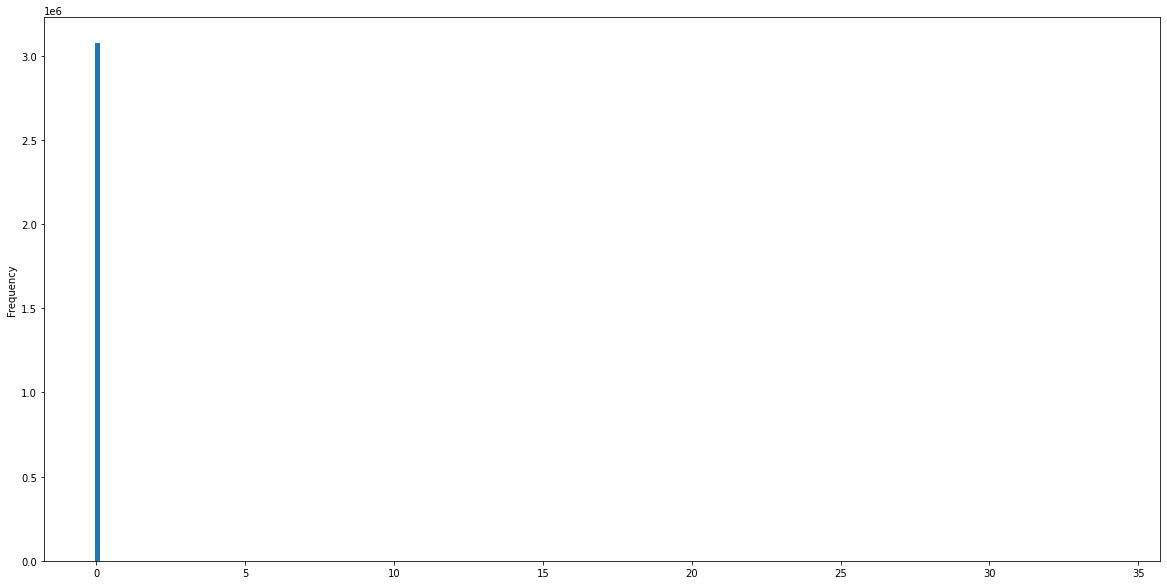

In [38]:
train['f_124'].plot(kind='hist', bins=200, figsize=(20,10))

In [39]:
train['f_124'].astype('float64').describe()

count    3.075965e+06
mean    -3.050452e-05
std      4.748020e-02
min     -4.168701e-02
25%     -1.472235e-05
50%      0.000000e+00
75%      1.126528e-05
max      3.403125e+01
Name: f_124, dtype: float64

This data is bad. I don't want to train on a feature that is 0 basically the entire time, and then sometimes is 30 -- let's drop `f_124` and check that it's the only feature like this. 

In [40]:
del train['f_124']
features = [col for col in train.columns if col.startswith('f_')]

In [41]:
train['f_170'].astype('float64').describe()

count    3.075965e+06
mean    -1.268144e-01
std      6.405679e-01
min     -4.230469e+00
25%     -4.655762e-01
50%      0.000000e+00
75%      6.030273e-02
max      4.207031e+00
Name: f_170, dtype: float64

In [42]:
train['f_182'].astype('float64').describe()

count    3.075965e+06
mean     3.901995e-01
std      7.530596e-01
min     -4.351562e+00
25%      0.000000e+00
50%      4.946289e-01
75%      1.000000e+00
max      4.523438e+00
Name: f_182, dtype: float64

The rest of these look broadly fine -- the lower standard deviation seems to be a normal outcome of combining a categorical variable (the 0s/1s/-1s) with a continuous variable. We should probably standardize these prior to training, however, otherwise they'll be downweighted for no real reason. 

Let's compute the correlation matrix and then plot the distribution of feature correlations with the target:

<AxesSubplot:title={'center':'Distribution of feature correlations with target'}, ylabel='Frequency'>

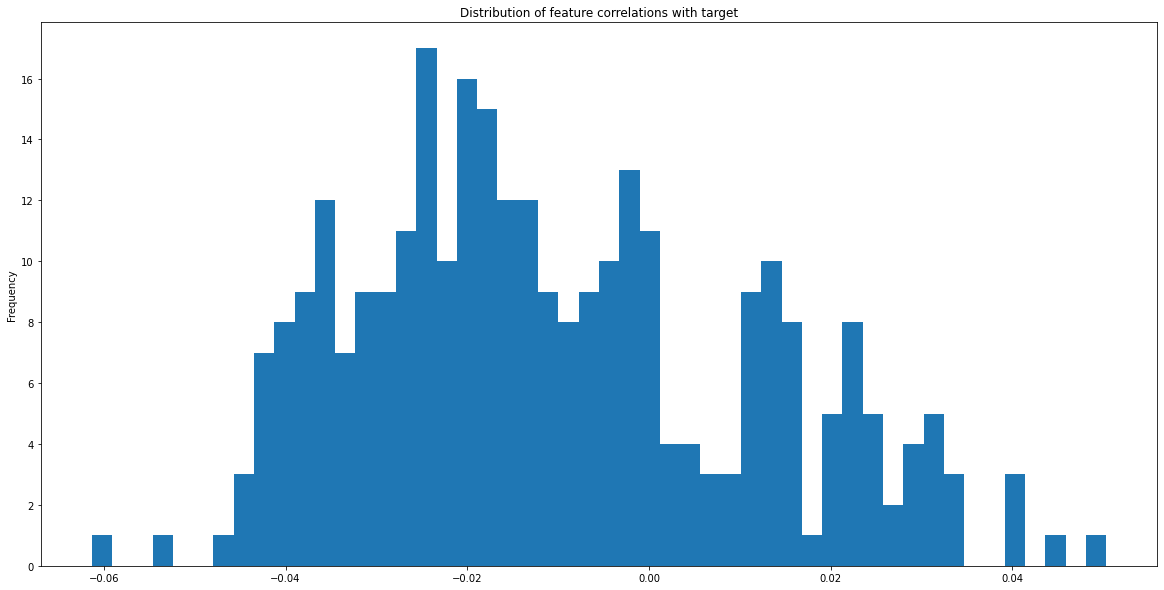

In [43]:
correlation = sample[[target] + features].corr()
(correlation[target]
 .iloc[1:]
 .plot(kind='hist',
       bins = 50, 
       figsize = (20,10),
       title='Distribution of feature correlations with target'))

There's very little (linear) signal in any of these individual features.

Let's see if there are any clusters in the data that we could use to reduce the dimensionality of the feature space or derive new features from:

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


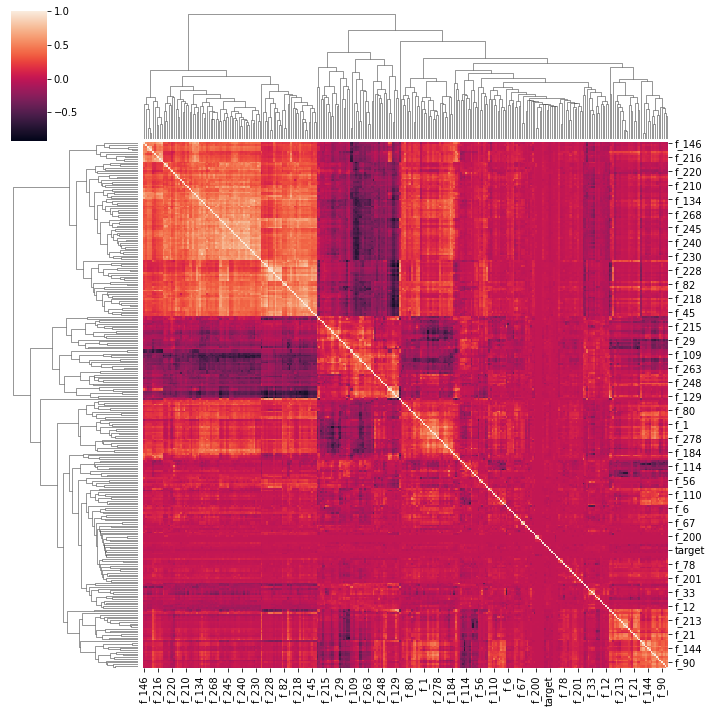

In [44]:
sns.clustermap(correlation, figsize=(10,10))

At a high level, I would say that about half of the data belongs to 2-3 fairly tight clusters of features, while the other half are more or less mutually orthogonal. I'll make some hierarchical clusters because that's what's visualized here, and then try some other clustering methods at a later date. 

#### A note on using `investment_id` for feature engineering: 

I don't think we can use `investment_id`s in the model. According to the competition description, there's no guarantee that any of the `investment_id`s in the training set will be present in the evaluation set -- that's not ideal, because you would think there would be some important information contained in the interplay between movements in different investments (e.g. when investment X and Y are both up in time t, then investment Z will often be down in time t+1). 

One way to exploit some of the information contained in the `investment_id`s without overfitting to the particular set of them contained in the training data would be to train a clustering algorithm on the set of investments that seem most likely to show up in the evaluation set (e.g. the investments that always show up in the training set) and then assign any new investments we encounter to one of those clusters before computing new features within- or cross-clusters. This procedure would have a lot of assumptions baked into it, however, about the validity of the clustering, so for now I'll avoid it, instead focusing on clustering like groups of features. 

Below I write a function that uses UMAP to non-linearly project the feature space into two dimensions before clustering these two-dimensional representations with HDBSCAN, plotting the resulting clusters. 

In [45]:
def cluster(data, plot=True, tag=''):
    reduced_dim_data = (umap
                        .UMAP(n_neighbors=5,
                              min_dist=0.15,
                              n_components=2,
                              random_state=42)
                        .fit_transform(data))
    clusters = (hdbscan
                .HDBSCAN(min_samples=15,
                         min_cluster_size=30)
                .fit_predict(reduced_dim_data))
    if plot:
        clustered = (clusters >= 0)
        
        fig = plt.figure(figsize=(15,15))
        ax  = plt.gca()

        ax.scatter(
            reduced_dim_data[clustered, 0],
            reduced_dim_data[clustered, 1],
            c=clusters[clustered]
        )

        ax.scatter(
            reduced_dim_data[~clustered, 0],
            reduced_dim_data[~clustered, 1],
            c='grey',
            alpha=0.5
        )

        ax.set_title(f'Two-dimensional UMAP projections of features, clustered with HDBSCAN \n Unclustered features in grey \n {tag}');
    
    # Return a dictionary indexed by the cluster label that contains the list of column names for each cluster
    return {x: pd.Series(data.index, index=clusters)[x].to_list() for x in set(clusters)}

Now let's run this clustering algorithm on two samples:

1. Full training data
2. Training data with `time_id`<400 excluded (corresponding to that large temporal break in the data)

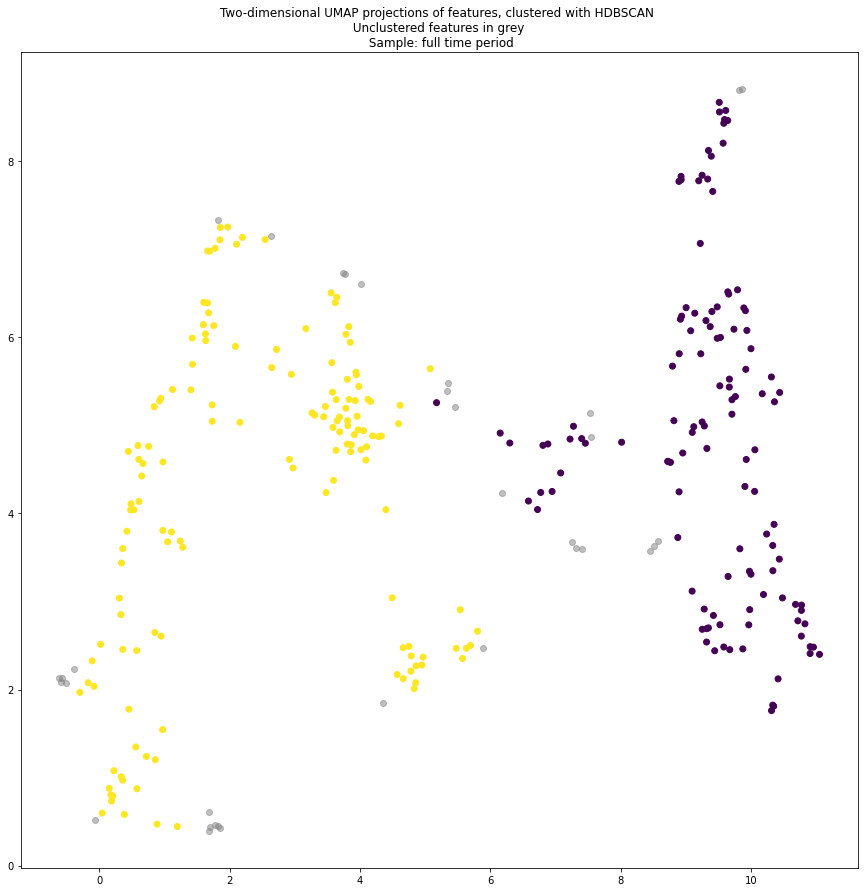

In [46]:
clusters_full_sample = cluster(train[features].T, tag='Sample: full time period')

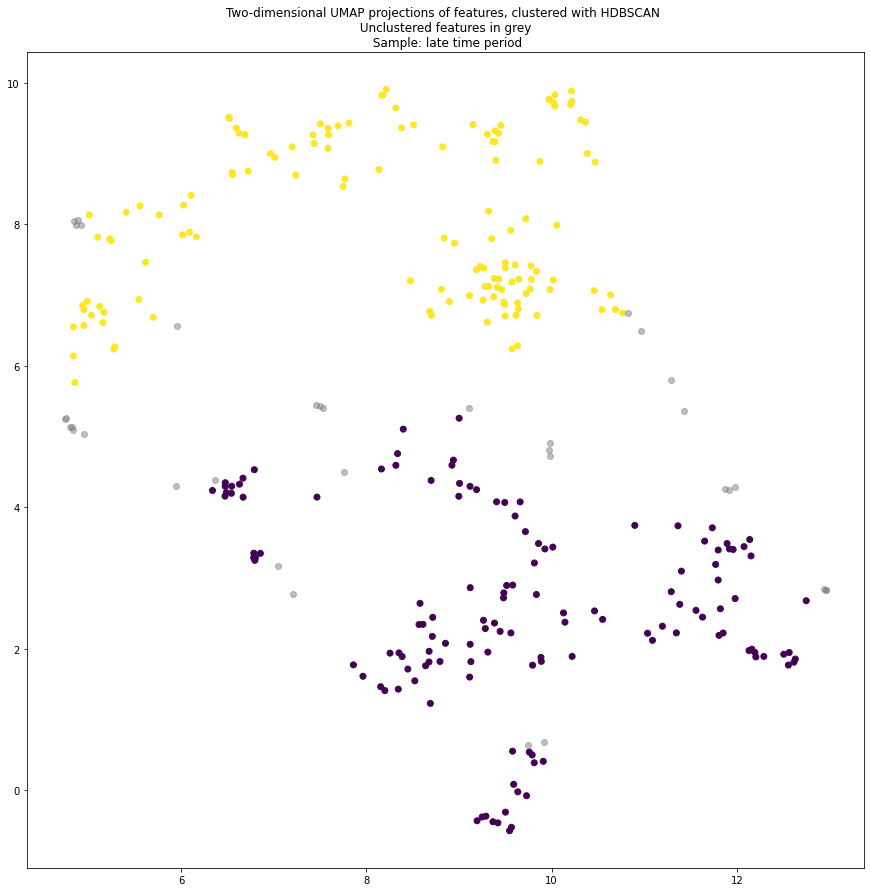

In [47]:
clusters_late_sample = cluster(train.loc[400:, features].T, tag='Sample: late time period')

Let's look at how much overlap there is in the cluster assignments between the two samples:

In [48]:
len(set(clusters_late_sample[1]).intersection(clusters_full_sample[1]))/len(clusters_late_sample[1])

0.9689922480620154

In [49]:
len(set(clusters_late_sample[0]).intersection(clusters_full_sample[0]))/len(clusters_late_sample[0])

0.8296296296296296

As you can see, the clustering algorithm (which I've tuned somewhat) produces very similar clusters when run on either the full sample or the late sample (dropping the data from before the big time break), which is good evidence of its robustness to time. In the future, I'll experiment with reducing the min_cluster_size parameter to see if there's any extra signal in additional clusters, but for now I'll err on the side of caution with larger/fewer clusters. In the next notebook I'll engineer some features based on the cross-sectional distributions of the features within each cluster. 

In [50]:
# Save our feature clusters
with open('feature_clusters.pickle', 'wb') as handle:
    pickle.dump(clusters_late_sample, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Cross-validation strategy

It's easy to rule out a couple of simple CV strategies:

1. Splitting the data randomly into folds will train the model on data collected *after* the holdout set, introducing leakage due to autocorrelations in the time series
2. Splitting the data by `investment_id` may introduce leakage because some of the anonymous features are calculated as aggregates of the values of other investments. 

This means that we must split by time, training our model on data from times $j<t_i$ and evaluating performance at time $t_i$ for $i=1,...,k$, where $k$ is the number of folds. I'm indebted to the code posted in this discussion for the GroupTimeSeriesSplit method: 
https://www.kaggle.com/c/ubiquant-market-prediction/discussion/304036

The competition data page tells us to "Expect to see roughly one million rows in the test set." I'd estimate that the number of time_ids to be predicted is: $1,000,000 / 3,579 = ~300$, where 3,579 is the number of `investment_id`s in the training set. Therefore I should ensure that my cross-validation strategy features holdout sets of size ~300. 

# Iterating on models

#### Version 1: simple LGBM (score: 0.098)

Below I plot the importance of the various features after running two 895-estimator LGBM models (with hyperparameters tuned locally according to the above 5-fold, `time_id`-based cross-validation strategy):
1. In the first I've thrown in the cluster-derived features
2. The second has only added features derived purely from cross-sectional variation in the 300 original features (i.e. no clustering involved) 

You can see that clustering doesn't help at all, and essentially none of the other smorgasbord of derived features help our model, so I will not pursue this kind of thing any further -- you'd expect that if the approach worked *at all*, then we'd see *some* improvement...

<AxesSubplot:title={'center':'Feature importance (gain): mean and standard deviation across 5 folds\nModel includes features derived from clusters'}, ylabel='feature'>

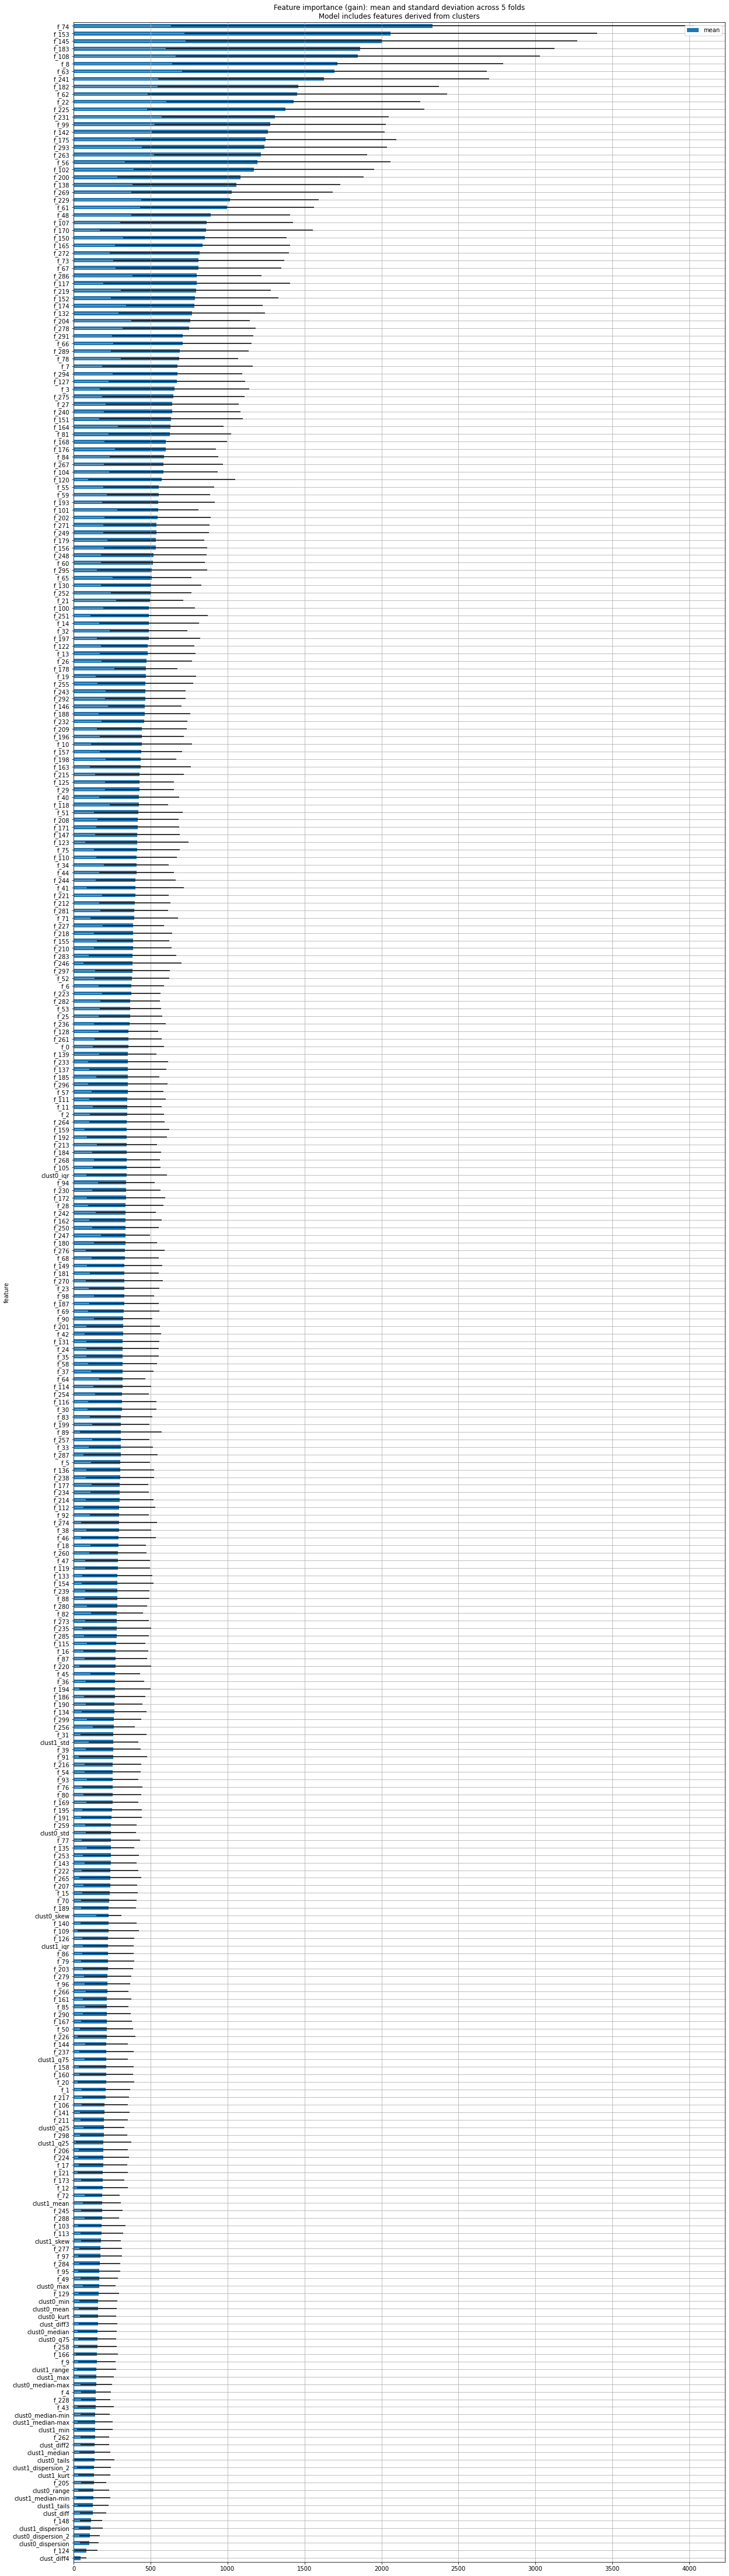

In [51]:
version = 1
scores, models, importance = pickle.load(open(f'../input/version{version}/results{version}.pkl', 'rb'))
(importance
 .groupby('feature')['importance']
 .aggregate(['mean','std'])
 .sort_values(by='mean')
 .plot(kind='barh',
       y='mean',
       xerr='std',
       grid=True,
       figsize=(20,80),
       title='Feature importance (gain): mean and standard deviation across 5 folds\n' 
       'Model includes features derived from clusters'))

<AxesSubplot:title={'center':'Feature importance (gain): mean and standard deviation across 5 folds\nModel includes features derived from cross-sectional distr. of original features'}, ylabel='feature'>

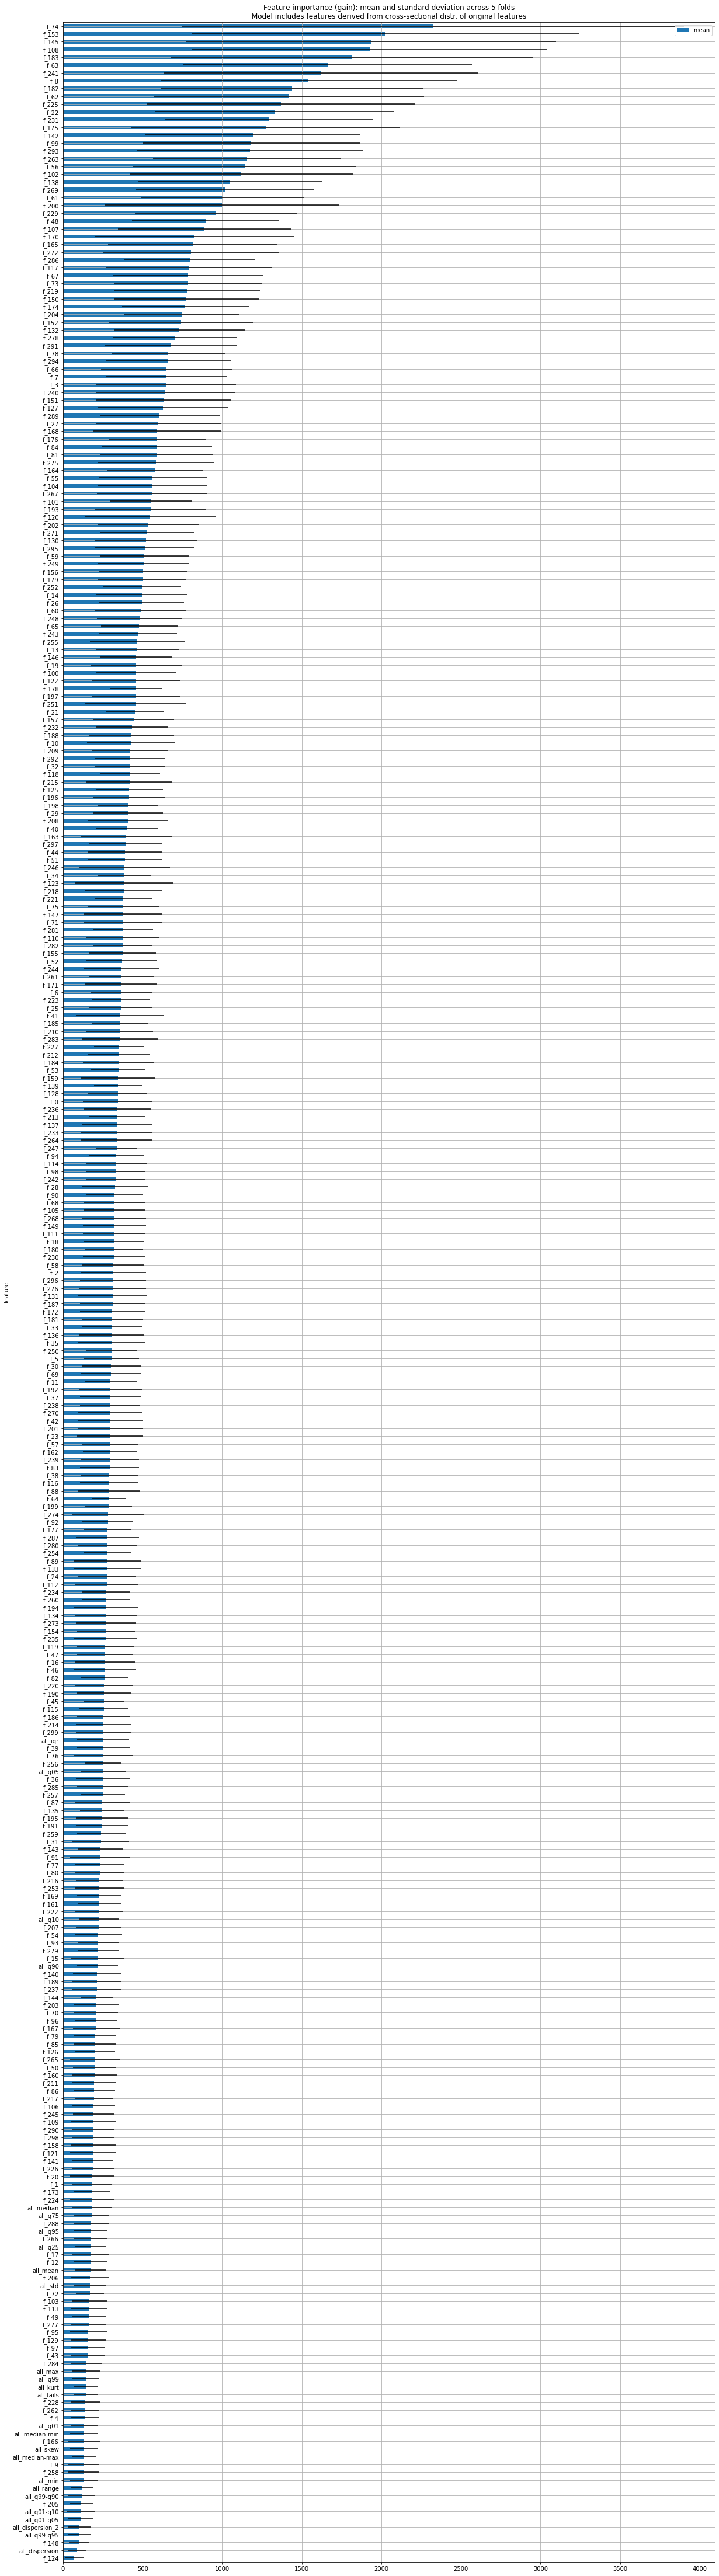

In [52]:
version = 2
scores, models, importance = pickle.load(open(f'../input/version{version}/results{version}.pkl', 'rb'))
(importance
 .groupby('feature')['importance']
 .aggregate(['mean','std'])
 .sort_values(by='mean')
 .plot(kind='barh',
       y='mean',
       xerr='std',
       grid=True,
       figsize=(20,80),
       title='Feature importance (gain): mean and standard deviation across 5 folds\n' 
       'Model includes features derived from cross-sectional distr. of original features'))

My score in the test data is ~0.10.

#### Version 2: DNN (score: 0.108)

#### Version 3: 50/50 ensemble of LGBM and DNN (score: 0.111)

# Discussion

I feel pretty good about the score of 0.111 with the ensemble approach. I'd note that the leaderboard is almost entirely scores of 0.15 -- I've looked at the code and these models all use `time_id` and `investment_id` extensively, e.g. directly using either as a feature or including lags or clusters of investments, and so I imagine these models will be way off during the evaluation phase due to the increased time-frequency of observations already discussed as well as the shuffled set of `investment_id`s. 

There are only two ways I think my score could be substantively improved while avoiding any of the above issues:
1. Find a better way to cluster the features
2. Use `investment_id` in some conservative way

(1) might work if I can infer the "speed" of the individual features, e.g. whether they're 30-day rolling averages versus intraday volatilities, and then include relevant statistics as features in the LGBM/DNN ensemble -- this might allow for a little more separation between long-term and short-term signals. 

(2) might allow me to cluster some `investment_id`s that are sure to show up, so that I'm no longer throwing away signal in the correlations between investments -- e.g. right now, I don't have anything that says "when some tech stocks go up, then the others are likely to go up as well." 

More on (2):
